In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
data_dir = './kaggle/input'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### Question 1
Do we need 4 independent models for 4 interesting features or is there some relationship between them? Lets quickly do pairwise plot to see. (Even before really reading into the feature descriptions)

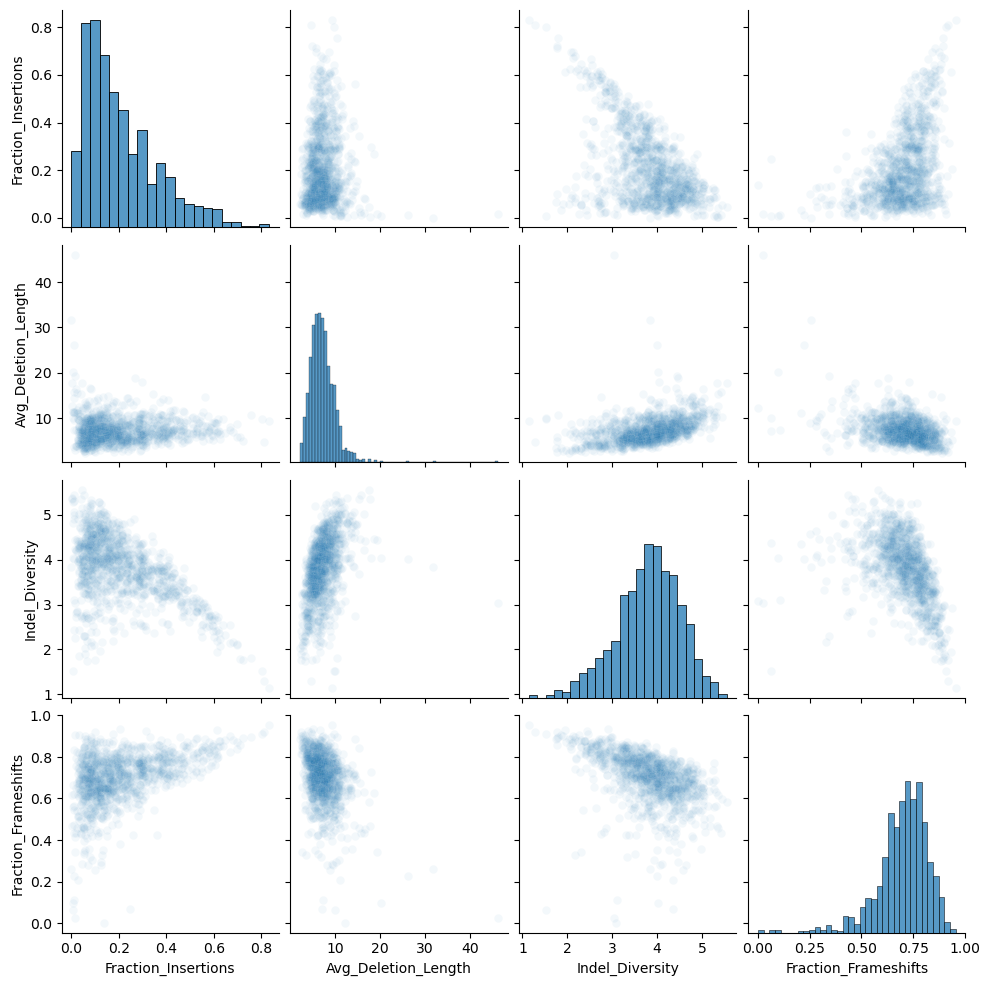

In [4]:
sns.pairplot(df_train.drop(columns=['GuideSeq', 'Id']), plot_kws={'alpha': 0.05})

### Question 2
All 4 features seem like aggregates of the data. Let's see how the were obtained in the paper (simultaneouly trying to not see their results :) ).

> This study involved 3,989 DNA repair profiles from T cells isolated from 18 individuals. These outcomes targeted 1,521 unique sites within 549 genes in the human genome.

From this we conclude that each individual dataset sample was aggregated from on average 3 "original data" samples, hence its predictive power may not be that high. There is no STD in the dataset, however the "Indel_diversity" is defined as follows:
> We use the entropy of the distribution of the reads over the indel types as a metric to quantify the diversity of the repair outcomes. If there is exactly one repair outcome in all of the reads, then the entropy is 0. Higher entropy means that the repair outcomes are more diverse.

which means that it can be used as a metric of how reliable prediction can be made for each individual sequence.

### Superficial observation 1
We have a lot more training datapoint than features that we will predict (none of predicted features are sequences, so no "expansion" foreseen), this is great, decreases our chances of overfitting.
There are no NAs and all the sequences of the same length, which is also great.

### Superficial observation 2
All PAMs used end in 'GG' so we can simply trim those 2 letters. The relevant length of GuideDna is 21. 

### Idea 1
It seems plausible that the outcomes are related to combinations of letters, so we should probably add synthetic columns. Quick estimation of what can reasonably fit in memory/cpu time. We have order 1000 rows, which means we will have 1kb/feature (as pandas allocates 1 byte/boolean + up to 500 bytes per column). Without columns overhead taken into account, one-hot encoding of single letters will generate 21*len('AGCT')*1kb = 84 kb. For 2 letters: 20 * len('AGCT')^2 * 1kb = 320 kb, For 3 letters: 19 * len('AGCT')^3 = 1_216 kb, etc

| letters used | memory usage (kb) (also, coincidentally, the number of additional features) |
| -------- | ------- |
|  1 | 80  |  
|  2 | 320 | 
|  3 | 1_216 |
|  4 | 4_608 |
|  5 | 17_408 |
|  6 | 65_536 |
|  7 | 245_760 |
|  8 | 917_504 |
|  9 | 3_407_872 |

With columns overhead on top, memory footprint should roughly 1.5-2x higher. (since we have ~1000 bytes for data and around ~500 bytes for column overhead). Hence it seems that one-hot encoding of 6-8 base pairs is reasonable. On the other hand introducing such high number of extra features will likely result in overfitting, which we will try to workaround by using Ridge regression.



In [5]:
# df_train['GuideSeq'] = df_train['GuideSeq'].str.slice(start=0, stop=21)

In [5]:

letters = ['A', 'T', 'G', 'C']
max_length = 3

def get_combinations(length):
    return [''.join(p) for p in product(letters, repeat=length)]

def make_letters_cols(data: pd.DataFrame):
    seq_len = len(data['GuideSeq'].iloc[0])
    # df_expanded = data['GuideSeq'].apply(lambda x: pd.Series(list(x)))
    # df_expanded.columns = [f'pos_{i+1}' for i in range(df_expanded.shape[1])]
    # data_expanded = pd.concat([data.drop(columns=['GuideSeq']), df_expanded], axis=1)
    
    acc = data
    for l in tqdm(range(1, max_length+1)):
        combinations = get_combinations(l)
        for pos in tqdm(range(0, seq_len - l + 1)):
            indices = ':'.join(str(i) for i in range(pos, l+pos))
            col_name = f'pos_{indices}'
            col_data = data["GuideSeq"].str.slice(start=pos, stop=pos+l)
            if l == 1:
                acc = pd.concat([acc, col_data.rename("letter_" + col_name).astype('category')], axis=1)
            for combination in combinations:
                col_name_2 = col_name + "_is_" + combination
                col_data_2 = col_data == combination
                acc = pd.concat([acc, col_data_2.rename(col_name_2)], axis=1)
    return acc

x = make_letters_cols(df_train)
x

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

,Id,GuideSeq,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts,letter_pos_0,pos_0_is_A,pos_0_is_T,pos_0_is_G,...,pos_20:21:22_is_CTG,pos_20:21:22_is_CTC,pos_20:21:22_is_CGA,pos_20:21:22_is_CGT,pos_20:21:22_is_CGG,pos_20:21:22_is_CGC,pos_20:21:22_is_CCA,pos_20:21:22_is_CCT,pos_20:21:22_is_CCG,pos_20:21:22_is_CCC
0,0,CTGCAGGGCTAGTTTCCTATAGG,0.069572,4.301844,3.536538,0.807375,C,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,GAGATGCGGACCACCCAGCTGGG,0.287647,10.814444,3.871165,0.665696,G,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2,GCAAACGGAAGTGCAATTGTCGG,0.137004,9.888889,3.931298,0.684823,G,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,3,GTCATCGCTGAGTTGAGGAAGGG,0.093889,4.527812,3.523067,0.753003,G,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,4,ATATGATTATCCCTGCACAAGGG,0.526525,6.415644,2.828101,0.887214,A,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,ATGCCCGACCAAAGACAACCAGG,0.093236,3.641787,3.170302,0.684801,A,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1061,1061,CACGCTGTCATCCACCAGGTAGG,0.069054,7.661831,4.284711,0.639433,C,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1062,1062,GGGCTCCAGAGTCTGATACAGGG,0.421439,7.364856,3.175859,0.832975,G,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1063,1063,AAAGACTTCGGTCCTCTAGTAGG,0.206277,7.907886,3.782588,0.528375,A,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.linear_model import Ridge
import sklearn.linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

def get_score(X: pd.DataFrame, y: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    return (lr.score(X_train, y_train), lr.score(X_test, y_test))

targets = ['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']
for t in targets:
    train, test = get_score(X=x.filter(regex='^pos_'), y=x[t])
    print(f'{t} (train): {train}')
    print(f'{t} (test): {test}')


Fraction_Insertions (train): 1.0
Fraction_Insertions (test): -4.624149915032933
Avg_Deletion_Length (train): 1.0
Avg_Deletion_Length (test): -14.621892985026626
Indel_Diversity (train): 1.0
Indel_Diversity (test): -10.546076412388077
Fraction_Frameshifts (train): 1.0
Fraction_Frameshifts (test): -13.823777378972103


Cross-Validation for Targets:   0%|          | 0/4 [00:00<?, ?it/s]

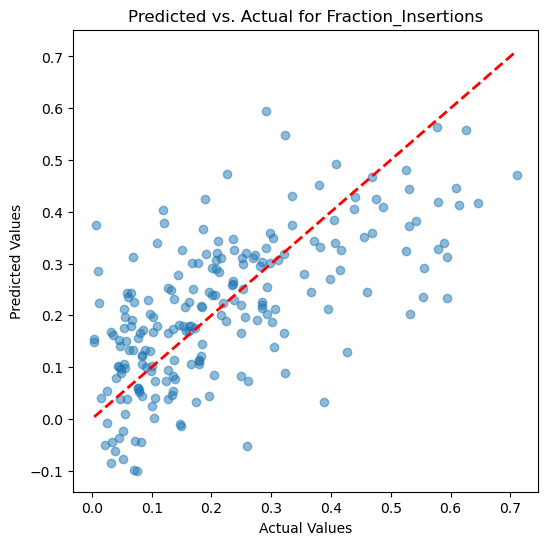

Cross-Validation for Targets:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]

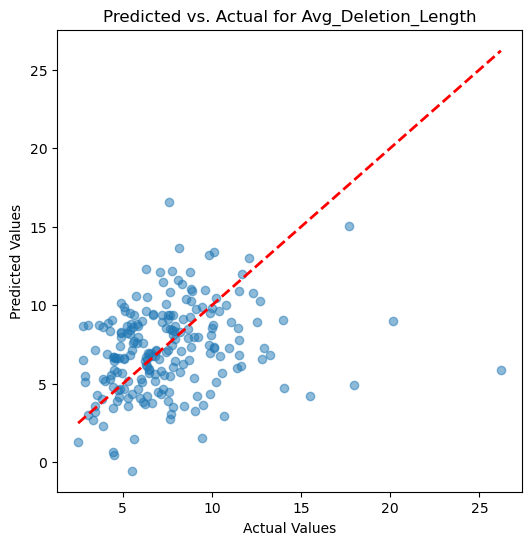

Cross-Validation for Targets:  50%|█████     | 2/4 [00:00<00:00,  2.42it/s]

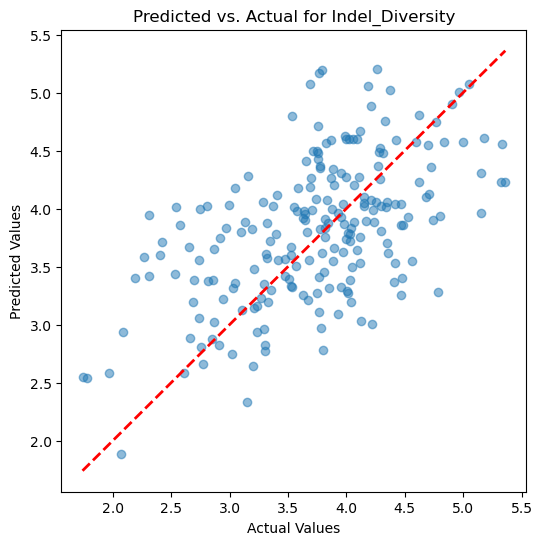

Cross-Validation for Targets:  75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

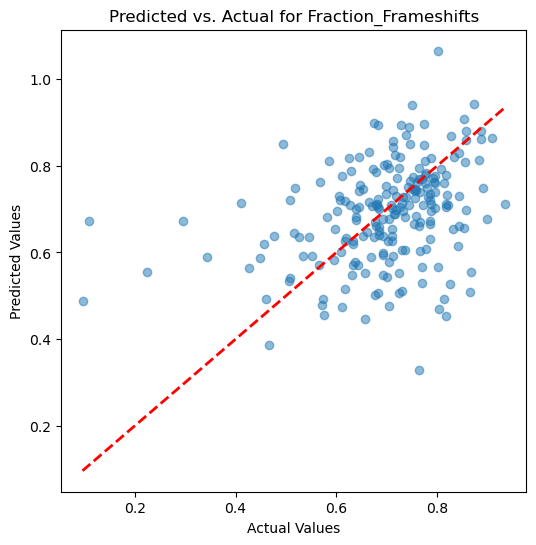

Cross-Validation for Targets: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


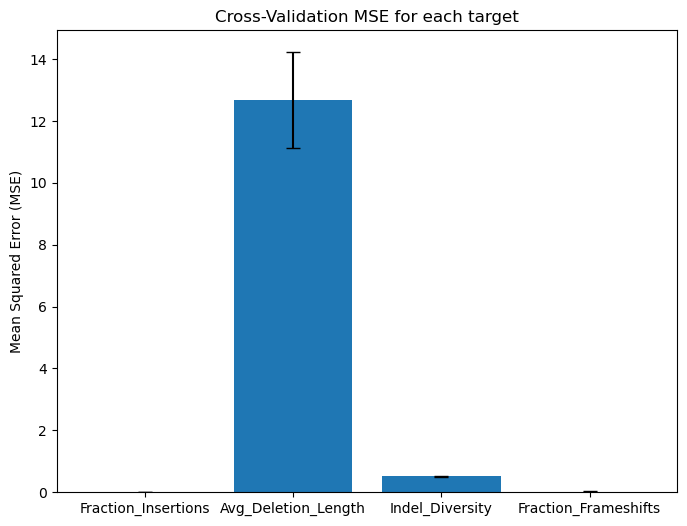

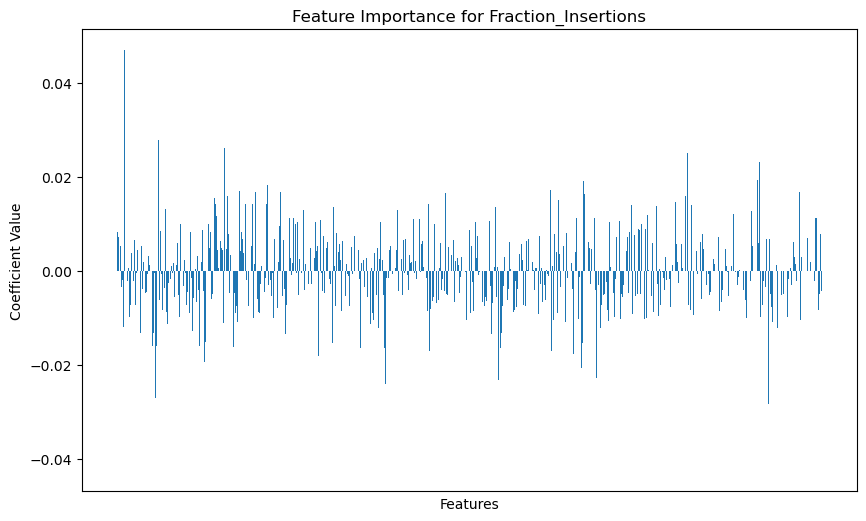

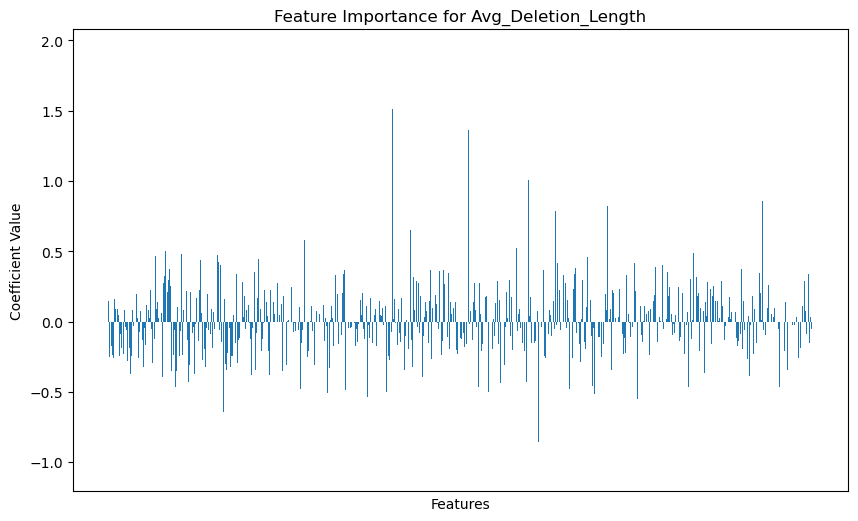

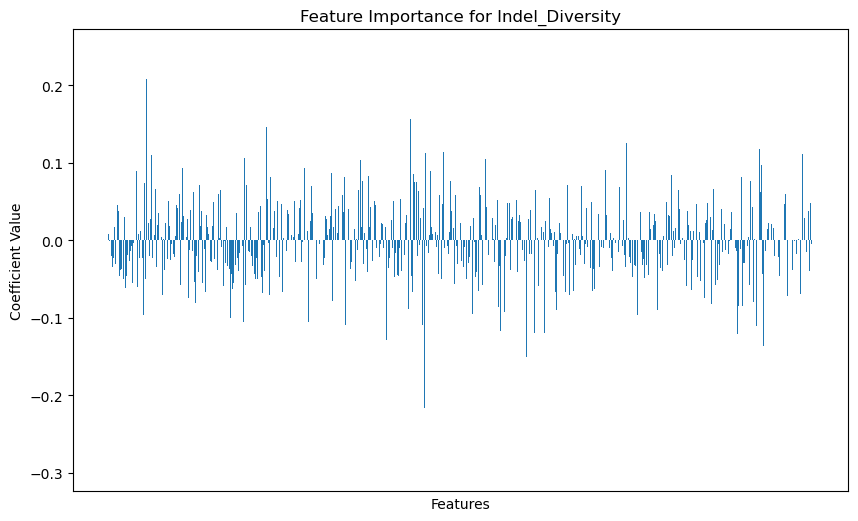

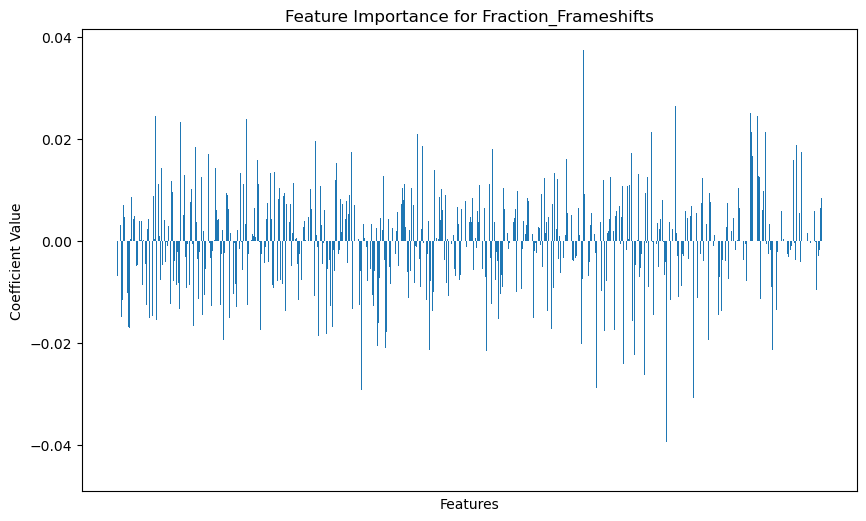

In [7]:

import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
data = x
# Assume 'data' is your DataFrame
# Select all columns starting with 'pos_' as features
X = data.filter(regex='^pos_')
targets = ['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']

# Visualization data
cv_results = {}
coefficients = {}

# Perform cross-validation for each target and store results
for target in tqdm(targets, desc="Cross-Validation for Targets"):
    y = data[target]
    
    # Split data for training and testing visualization
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize Ridge regression model
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # Cross-Validation MSE
    cv_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_results[target] = {
        'mean_mse': -np.mean(cv_mse_scores),
        'std_mse': np.std(cv_mse_scores)
    }
    
    # Store coefficients for feature importance
    coefficients[target] = model.coef_
    
    # Predicted vs. Actual plot
    y_pred = model.predict(X_test)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs. Actual for {target}")
    plt.show()

# Plotting Cross-Validation MSE
means = [cv_results[target]['mean_mse'] for target in targets]
stds = [cv_results[target]['std_mse'] for target in targets]
plt.figure(figsize=(8, 6))
plt.bar(targets, means, yerr=stds, capsize=5)
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Cross-Validation MSE for each target")
plt.show()

# Plotting Feature Coefficients
for target in targets:
    plt.figure(figsize=(10, 6))
    plt.bar(X.columns, coefficients[target])
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.title(f"Feature Importance for {target}")
    plt.xticks([]) 
    plt.show()



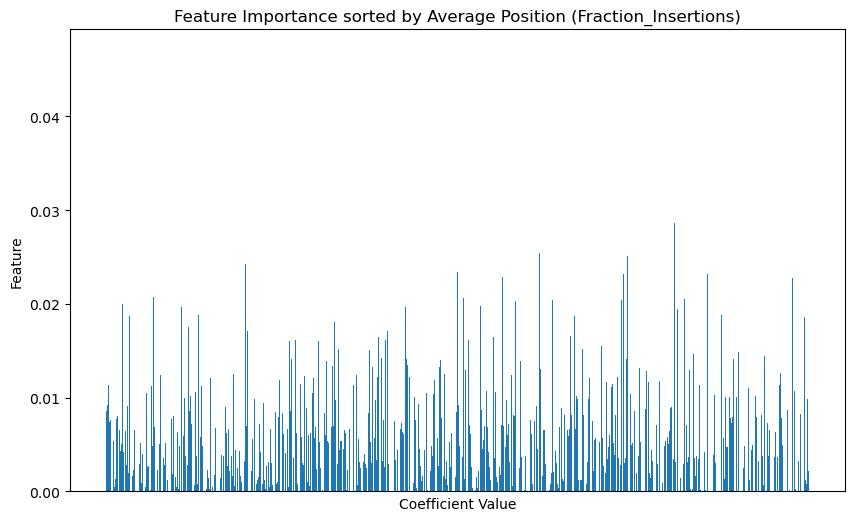

,feature,coefficient,avg_position
0,pos_0_is_A,-0.007938,0.0
1,pos_0_is_T,0.005844,0.0
2,pos_0_is_G,-0.006219,0.0
3,pos_0_is_C,0.008314,0.0
4,pos_1_is_A,-0.002684,1.0
...,...,...,...
6223,pos_17:18:19:20_is_CCGC,-0.004639,18.5
6224,pos_17:18:19:20_is_CCCA,-0.010060,18.5
6225,pos_17:18:19:20_is_CCCT,0.000000,18.5
6226,pos_17:18:19:20_is_CCCG,-0.004365,18.5


In [8]:
import re

feature_names = X.columns

# Step 1: Parse positional information and compute the average position
positions = []
for col in feature_names:
    # Extract positions from the column name (e.g., 'pos_1:2:3:4_is_ATCG')
    pos_list = re.findall(r'\d+', col)
    pos_list = list(map(int, pos_list))  # Convert extracted positions to integers
    avg_position = np.mean(pos_list)  # Calculate average position
    positions.append(avg_position)

target = 'Fraction_Insertions'  # Specify the target for which to visualize importance
df_features = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients[target],
    'avg_position': positions
})

df_features_sorted = df_features.sort_values(by='avg_position')

plt.figure(figsize=(10, 6))
plt.bar(df_features_sorted['feature'], df_features_sorted['coefficient'].abs())
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f"Feature Importance sorted by Average Position ({target})")
plt.xticks([])
plt.show()

df_features

Model Comparison for Targets:   0%|          | 0/4 [00:00<?, ?it/s]


ValueError: could not convert string to float: 'C'

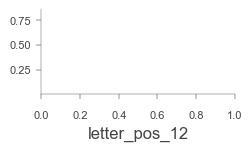

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import xgboost as xgb
import dtreeviz
# Assume 'data' is your DataFrame, and it contains both 'pos_' and 'letter_pos_' prefixed columns.

# Select features for each model
X_ridge = data.filter(regex='^pos_')           # Features for Ridge (columns starting with 'pos_')


X_xgb = data.filter(regex='^letter_pos_')      # Features for XGBoost (columns starting with 'letter_pos_')
# for col in X_xgb.columns:
#     if X_xgb[col].dtype == 'object':
#         X_xgb[col] = X_xgb[col].astype('category')

# Define target columns
targets = ['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']

# Dictionary to store models and results
ridge_results = {}
xgb_results = {}
ridge_models = {}
xgb_models = {}

# Training Ridge and XGBoost for comparison
for target in tqdm(targets, desc="Model Comparison for Targets"):
    y = data[target]
    
    # Ridge model (using 'pos_' features)
    ridge_model = Ridge(alpha=1.0)
    ridge_cv_mse = -cross_val_score(ridge_model, X_ridge, y, cv=5, scoring='neg_mean_squared_error')
    ridge_results[target] = {'mean_mse': np.mean(ridge_cv_mse), 'std_mse': np.std(ridge_cv_mse)}
    ridge_model.fit(X_ridge, y)
    ridge_models[target] = ridge_model
    
    # XGBoost model (using 'letter_pos_' features)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, enable_categorical=True)
    xgb_cv_mse = -cross_val_score(xgb_model, X_xgb, y, cv=5, scoring='neg_mean_squared_error')
    xgb_results[target] = {'mean_mse': np.mean(xgb_cv_mse), 'std_mse': np.std(xgb_cv_mse)}
    xgb_model.fit(X_xgb, y)
    xgb_models[target] = xgb_model


    X_numeric = X.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)


    viz_model = dtreeviz.model(xgb_model, tree_index=1,
                            X_train=X_xgb, y_train=y,
                            feature_names=list(X_xgb.columns),
                            target_name=target, class_names=["perish", "survive"])
    viz_model.view()

# Display comparison results
print("Model Performance Comparison (Mean Squared Error)")
for target in targets:
    print(f"\n{target}:")
    print(f" Ridge - Mean MSE: {ridge_results[target]['mean_mse']:.4f}, Std MSE: {ridge_results[target]['std_mse']:.4f}")
    print(f" XGBoost - Mean MSE: {xgb_results[target]['mean_mse']:.4f}, Std MSE: {xgb_results[target]['std_mse']:.4f}")

There is no layout engine support for "dot"
Perhaps "dot -c" needs to be run (with installer's privileges) to register the plugins?


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tpng']' returned non-zero exit status 1. [stderr: b'There is no layout engine support for "dot"\nPerhaps "dot -c" needs to be run (with installer\'s privileges) to register the plugins?\n']

<Figure size 2000x1000 with 0 Axes>

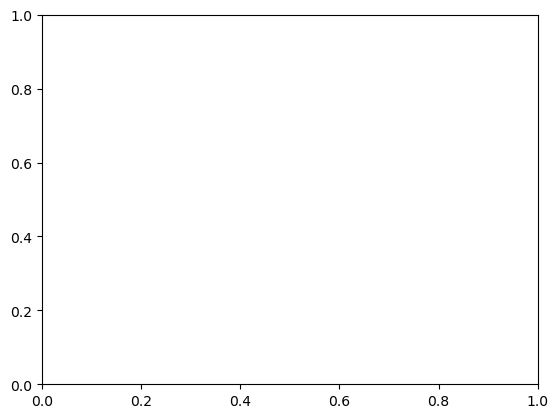